<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    Être ou ne pas être ?
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un problème de classification binaire sur des données médicales artificelles
<br/>

---

# Membres du groupe

**Minimum 2, Maximum 3**

<span style="color:red">
    Répondre ci-dessous
</span>

* Almeida de Oliveira, Frédéric
* Manea, Théo
* Seanz, Quentin

# Présentation du challenge

## La question principale de ce challenge est : 

* Comment prédire la survie d'un patient compte tenu de son dossier médical ? 
    
* Plus précisément, vous devrez prédire la survie des patients pendant leur séjour à l'hôpital
 
Chaque jour, le personnel soignant collecte de nombreuses informations sur les patients en posant des questions et en utilisant des outils de mesure (stéthoscope, analyse de sang, capteurs, etc.). Ces données sont très utiles pour surveiller l'état de santé, diagnostiquer et choisir les traitements.

Elles peuvent également être utilisées pour l'analyse statistique prédictive.

## Données

L'ensemble de données contient des informations sur 80'000 patients, représentés par des variables (descripteurs) catégorielles, binaires et numériques. Ces variables sont, par exemple, l'âge, le sexe, l'origine ethnique, l'état matrimonial, ainsi que des données médicales telles que la tension artérielle ou le taux de glucose. Il y a un total de 342 variables.

La classe (étiquette ou label) à prédire est une variable binaire indiquant si le patient est décédé ou non pendant son séjour à l'hôpital. Heureusement, la plupart d'entre eux survivent :

![](img/tobe.png)

## Tâche

La tâche consiste à créer un modèle capable d'apprendre à partir des données et de faire des prédictions (apprentissage supervisé). Chaque instance (patient) possède une variable indiquant si elle·il est décédé·e ou non pendant son séjour à l'hôpital.

Références et crédit :

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

Le but de ce TP est de travailler sur un challenge de prédiction de la mortalité.

Le lien vers le challenge :
https://competitions.codalab.org/competitions/30715

* **Étape 1 :** S'enregistrer sur https://competitions.codalab.org
* **Étape 2:** Téléchargez le jeu de données à partir de la [page](https://competitions.codalab.org/competitions/30715#participate-get_starting_kit) "Participate > Files > Public Data". Placez le dossier "public_data" dans le même dossier que celui contenant ce notebook.
* **Étape 3:** Parcourez ce notebook. Vous devrez lire, exécuter, **coder vos propres méthodes** et **répondre aux questions**. Utilisez la cellule ***code*** pour le codage et la cellule ***markdown*** pour répondre aux questions.

## Évaluation du projet

* **4 points** pour la partie compréhension et analyse exploratoire
    
* **4 points** pour un code propre et bien documenté

* **4 points** pour la qualité du modèle (sélection du modèle, sélection des hyperparamètres)

* **4 points** pour une bonne évaluation des performances du modèle

* **4 points** pour l'originalité et la complétude de la solution 

* **1 point bonus** pour l'équipe gagnante du challenge

### FAQ

* Soumettre uniquement le notebook sur eCampus

* La partie texte (explications, résultats, problèmes, sans le code) ne doit pas dépasser 3 pages A4 11pt (< 1500 mots)

# Challenge

Module particulier requis : `imblearn` (à installer avec `conda` ou `pip`)

* `conda install -c conda-forge imbalanced-learn`

* `pip install imbalanced-learn`

In [1]:
!pip install imbalanced-learn
from datetime import datetime
from pathlib import Path
from zipfile import ZipFile

import imblearn
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import (
    decomposition,               # - Réduction de dimensions
    discriminant_analysis,       # - Classifier quadratique ou linéaire
    ensemble,                    # - Combine les prédictions d'estimateurs de base créés selon un algorithme. 2 types:
                                 #average = création de plusieurs estimateurs indépendants et moyenne des résultats (ex: bagging, forest,...)
                                 #boosting = création séquencielle d'estimateurs, l'un essaye de réduire le taux d'erreur des autres (ex : AdaBoost, Gradient,...)
    linear_model,                # - Models linéaires (regression linéaire, ridge, lasso, ...)
    metrics,                     # - Calcul du score (accuracy, balanced_accuracy, ...)
    model_selection,             # - Optimisation du modèle (hyperparamètres, cross_val_score, ...)
    naive_bayes,                 # - Algorithmes d'apprentissage supervisé basés sur les théorèmes de Bayes (gaussien, multinomial,...)
    pipeline,                    # - Création de l'estimateur (fin du projet)
    preprocessing,               # - Modification du dataset pour avoir des données plus simples à utiliser par les modèles
    svm,                         # - Modèles vectoriels
)

In [2]:
%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.4g}".format

## 1. Compréhension du problème

### Expliquez brièvement la tâche avec vos mots

<span style="color:red">
    Répondre ci-dessous
</span>

Nous allons devoir créer un modèle capable de prédire la survavibiliré d'un patient en nous basant sur une base de données.

### Métrique utilisée

Pourquoi la métrique utilisée ici est la [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) plutôt que simplement l'[`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) ?

<span style="color:red">
    Répondre ci-dessous
</span>

On utilise la métrique "balanced accuracy" car notre dataset n'est pas équilibré et la méthode "accuracy" est donc moins précise.

## 2. Chargement les données

In [3]:
DATA = Path(
    "~\Documents\Cours\L2\S4\ISD2\Projet IS2D\public_data" # À modifier selon la personne
).expanduser()

# DATA = Path("public_data")

PRED_PATH = Path("Submissions")

DROP_VARS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

In [4]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove time related data that are not needed
x_df.drop(columns=DROP_VARS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [5]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0


C'est **l'ensemble d'entrainement**. Cela signifie que vous avez accès aux étiquettes et que vous pouvez l'utiliser comme vous le souhaitez pour préparer votre modèle.

Plus tard, vous ferez en sorte que votre modèle tire des prédictions de **l'ensemble de test** afin de les télécharger sur Codalab et d'obtenir un score sur des données non-vues.

In [6]:
# Load testing set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove time related data that are not needed
x_test_df.drop(columns=DROP_VARS, inplace=True)

## 3. Analyse exploratoire

#### Types des variables

In [7]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64

#### Labels distribution

In [8]:
ys.describe()

count     8e+04
mean    0.03496
std      0.1837
min           0
25%           0
50%           0
75%           0
max           1
dtype: float64

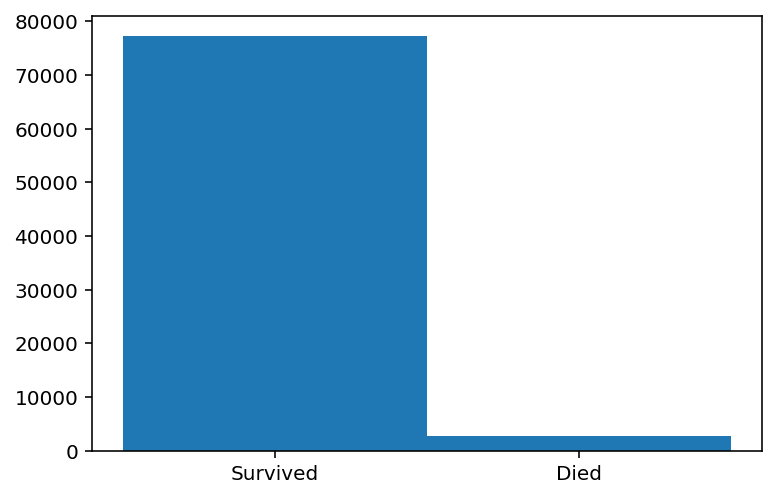

In [9]:
ys.hist(bins=2, grid=False, align="left")
plt.xticks([0, 0.5], ["Survived", "Died"])
# plt.savefig("img/tobe.png", dpi=300)
plt.show()

### Code : Produire les graphiques suivants

* Diagrammes à barres de certaines variables catégorielles (par exemple "LANGUAGE", "MARITAL_STATUS")

* Montrez la corrélation entre certaines variables et la variable cible y

* Un autre graphique ou toute analyse exploratoire à laquelle vous pouvez penser

Exemple

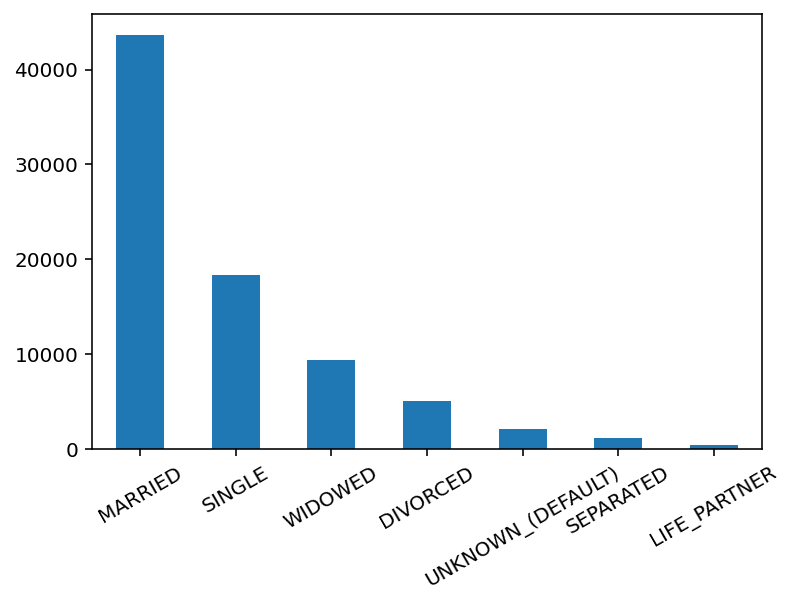

In [10]:
x_marital_cnts = x_df["MARITAL_STATUS"].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.show()

<span style="color:red">
    Répondre ci-dessous
</span>

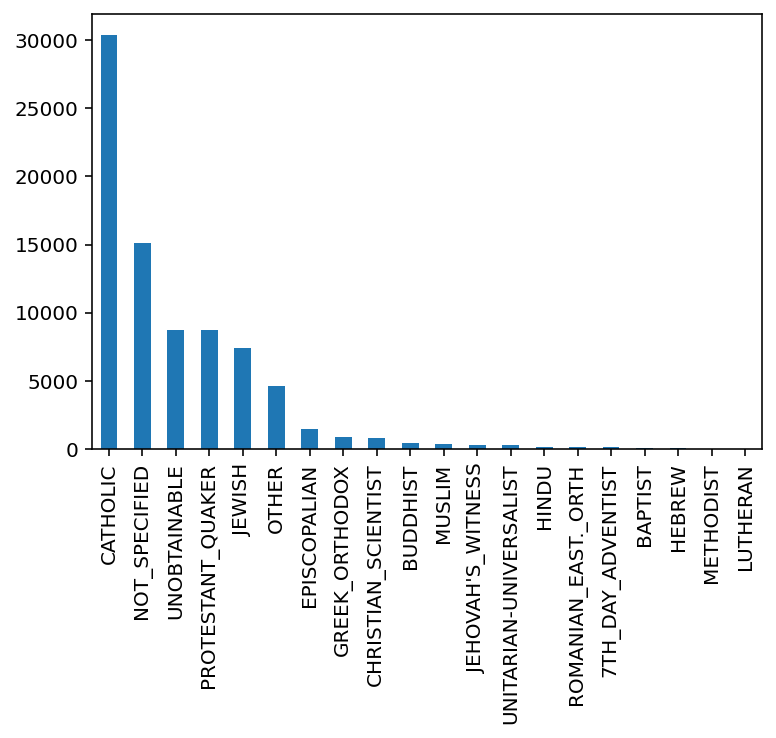

In [11]:
# Test pour la variable religion

x_language_counts = x_df["RELIGION"].value_counts()
x_language_counts.plot.bar(rot=90)
plt.show()

#### Correlations

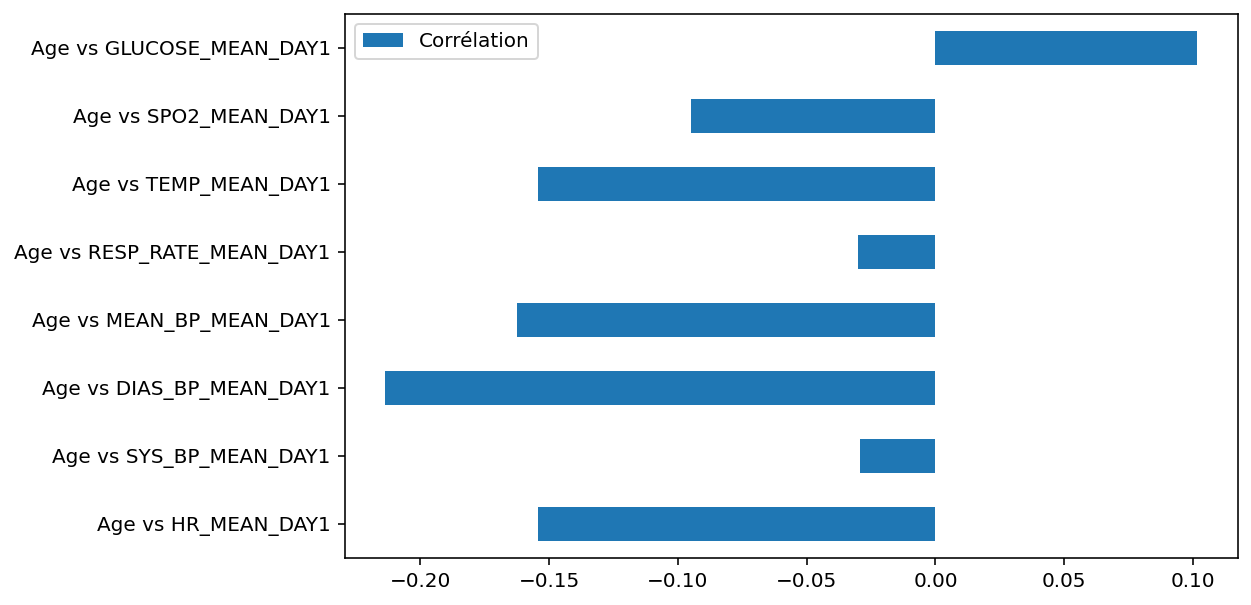

In [12]:
# TODO: Bar plot of the most correlated variables with y

# On définit age comme la valeur de référence
age = x_df["AGE"]

# On définit ensuite les valeurs auxquelles nous allons la comparer
hr_mean_day1 = x_df["HR_MEAN_DAY1"]
sys_bp_mean_day1 = x_df["SYS_BP_MEAN_DAY1"]
dias_bp_mean_day1 = x_df["DIAS_BP_MEAN_DAY1"]
mean_bp_mean_day1 = x_df["MEAN_BP_MEAN_DAY1"]
resp_rate_mean_day1 = x_df["RESP_RATE_MEAN_DAY1"]
temp_mean_day1 = x_df["TEMP_MEAN_DAY1"]
spo2_mean_day1 = x_df["SPO2_MEAN_DAY1"]
glucose_mean_day1 = x_df["GLUCOSE_MEAN_DAY1"]

# On calcule la corrélation entre age et les autre valeurs
ahr = np.corrcoef(age, hr_mean_day1)
asys = np.corrcoef(age, sys_bp_mean_day1)
adias = np.corrcoef(age, dias_bp_mean_day1)
amean = np.corrcoef(age, mean_bp_mean_day1)
aresp = np.corrcoef(age, resp_rate_mean_day1)
atemp = np.corrcoef(age, temp_mean_day1)
aspo = np.corrcoef(age, spo2_mean_day1)
aglucose = np.corrcoef(age, glucose_mean_day1)

# On réalise le graphique correspondant
graph = pd.DataFrame([[ahr[0][1]], [asys[0][1]], [adias[0][1]], [amean[0][1]], [aresp[0][1]], [atemp[0][1]],
                        [aspo[0][1]], [aglucose[0][1]]],
                    index=['Age vs HR_MEAN_DAY1', 'Age vs SYS_BP_MEAN_DAY1', 'Age vs DIAS_BP_MEAN_DAY1',
                           'Age vs MEAN_BP_MEAN_DAY1', 'Age vs RESP_RATE_MEAN_DAY1', 'Age vs TEMP_MEAN_DAY1',
                           'Age vs SPO2_MEAN_DAY1', 'Age vs GLUCOSE_MEAN_DAY1'],
                    columns=['Corrélation'])
graph.plot.barh(figsize=(8,5))


Hint:

* Utilisez un graphique avec des barres horizontales `barh` (pour visualiser les valeurs positives et négatives)

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

On voit à l'aide de ce graphique la correlation entre l'age et les autres valeurs que nous avont selectionnées.

#### Autres graphiques

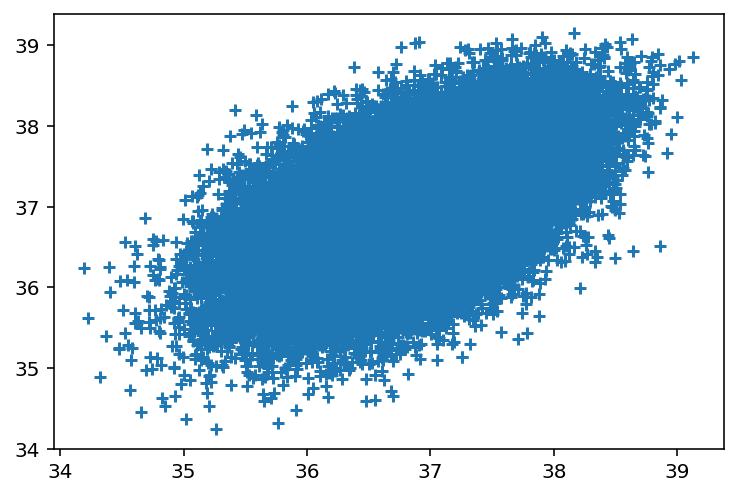

In [13]:
# TODO: Add graph

# On va faire regarder l'évolution de la température des patients entre le jour 1 et le jour 2

temp1 = x_df["TEMP_MEAN_DAY1"]
temp2 = x_df["TEMP_MEAN_DAY2"]

plt.scatter(temp1,temp2, marker='+')

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

On voit que les points de graphique se rapprochent de la fonction affine y=x, ce qui montre une faible variation de la température d'unjour à l'autre.

## 4. Pre-traitement

### Code : Traitement du problème des valeurs manquantes (ou non-définies, NAN)

#### Avant:
La solution la plus simple est d'éliminer l'ensemble des colonnes où il y a des données manquantes, mais on perd de l'information. 

Notez qu'il faut supprimer l'union des colonnes en question pour l'ensemble d'entrainement et de test, afin de garder des dimensions cohérentes.

#### Aprés:
La solution la plus simple est d'éliminer l'ensemble des colonnes où il y a des données manquantes, mais on perd de l'information. 

Vu le faible nombre d'instances concernées (maximum 6 : voir ci-dessous) il parait plus pertinent de supprimer les lignes (instances) plutôt que les colonnes entières (variables).

La solution que nous choisissons ici est une troisième, celle de remplacer les valeurs non définies par la valeur la plus probable de la variable. Comme ces valeurs manquantes concernent exclusivement des variables catégorielles et binaires, la valeur la plus probable est le *mode* (voir cours : `part-5-slides.pdf`).

In [14]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


In [15]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_miss

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

In [16]:
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]
x_test_miss

LANGUAGE                              2
ECodes:Adverseeffectsofmedicalcare    3
dtype: int64

In [17]:
x_miss_rows = x_df.isna().any(axis="columns")

x_df.loc[x_miss_rows, x_miss.index]

,LANGUAGE,MARITAL_STATUS,ICU,ECodes:Adverseeffectsofmedicalcare,Otnutritdx,Othnervdx
2251,ENGL,MARRIED,MICU,nan,0,0
9983,ENGL,MARRIED,MICU,0,nan,0
10549,ENGL,MARRIED,MICU,0,nan,0
10831,ENGL,MARRIED,MICU,nan,1,0
17012,ENGL,MARRIED,CSRU,nan,0,1
23088,ENGL,MARRIED,NaN,0,0,0
32539,ENGL,NaN,CSRU,0,0,0
42762,ENGL,SINGLE,TSICU,nan,0,0
53191,NaN,MARRIED,MICU,0,0,0
53390,CAPE,MARRIED,NaN,0,0,0


#### Remplacement des NAN

In [18]:
na_cols = set(x_miss.index) | set(x_test_miss.index)

for col in na_cols:
    x_df[col].fillna(x_df[col].mode()[0], inplace=True)
    x_test_df[col].fillna(x_test_df[col].mode()[0], inplace=True)

In [19]:
print(x_df.isna().any().any(), x_test_df.isna().any().any())

False False


In [20]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


#### Les cellules suivantes en commentaire sont la résolution de la version précédente du sujet (cf 'Avant')

In [21]:
'''na_cols = set(x_df.columns[x_df.isna().any()]) | set(
    x_test_df.columns[x_test_df.isna().any()]
)
na_cols'''

'na_cols = set(x_df.columns[x_df.isna().any()]) | set(\n    x_test_df.columns[x_test_df.isna().any()]\n)\nna_cols'

In [22]:
'''x_df.drop(columns=na_cols, inplace=True)
x_test_df.drop(columns=na_cols, inplace=True)'''

'x_df.drop(columns=na_cols, inplace=True)\nx_test_df.drop(columns=na_cols, inplace=True)'

In [23]:
'''print(x_df.isna().any().any(), x_test_df.isna().any().any())'''

'print(x_df.isna().any().any(), x_test_df.isna().any().any())'

In [24]:
'''print(x_df.shape, x_test_df.shape)'''

'print(x_df.shape, x_test_df.shape)'

In [25]:
'''Proposez d'autre(s) stratégie(s) pour traiter le problème des NAN.'''

"Proposez d'autre(s) stratégie(s) pour traiter le problème des NAN."

In [26]:
'''Répondre ci-dessous'''

'Répondre ci-dessous'

In [27]:
'''# TODO: other handling of NAN to replace the preciding column drop

# On décide de remplacer les valeurs non définies par le valeur la plus présente dans la catégorie

#----------------------------------------------#

# On initialise x_df et x_test_df

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)
x_df.drop(columns=DROP_VARS, inplace=True)

x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)
x_test_df.drop(columns=DROP_VARS, inplace=True)

#----------------------------------------------#

# On cherche en suite les colonnes pour lesquelles il manque des valeurs et combien il en manque

x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]

x_df_miss_columns = x_df.columns[x_df.isna().any()]
x_test_miss_columns = x_test_df.columns[x_test_df.isna().any()]

#----------------------------------------------#

# On calcule la valeur la plus présente dans chaque catégorie et on remplace la valeur manquante par cette dernière

most_present_value_test_df = x_test_df[x_test_miss_columns[0]].value_counts().idxmax()
most_present_value_df = x_df[x_df_miss_columns[0]].value_counts().idxmax()

# Remplacement pour x_test_df
for i in range (len(x_test_miss_columns)):
    x_test_df[x_test_miss_columns[i]] = x_test_df[x_test_miss_columns[i]].fillna(0)
    x_test_df[x_test_miss_columns[i]] = x_test_df[x_test_miss_columns[i]].replace([0], most_present_value_test_df)

# Remplacement pour x_df
for i in range (len(x_df_miss_columns)):
    x_df[x_df_miss_columns[i]] = x_df[x_df_miss_columns[i]].fillna(0)
    x_df[x_df_miss_columns[i]] = x_df[x_df_miss_columns[i]].replace([0], most_present_value_df)

#----------------------------------------------#

print(x_df.shape, x_test_df.shape)'''

'# TODO: other handling of NAN to replace the preciding column drop\n\n# On décide de remplacer les valeurs non définies par le valeur la plus présente dans la catégorie\n\n#----------------------------------------------#\n\n# On initialise x_df et x_test_df\n\nx_df = pd.read_csv(\n    DATA / "mimic_synthetic_train.data",\n    header=None,\n    names=features,\n    sep=" ",\n)\nx_df.drop(columns=DROP_VARS, inplace=True)\n\nx_test_df = pd.read_csv(\n    DATA / "mimic_synthetic_test.data",\n    header=None,\n    names=features,\n    sep=" ",\n)\nx_test_df.drop(columns=DROP_VARS, inplace=True)\n\n#----------------------------------------------#\n\n# On cherche en suite les colonnes pour lesquelles il manque des valeurs et combien il en manque\n\nx_nans = x_df.isna().sum()\nx_miss = x_nans[x_nans > 0]\nx_test_nans = x_test_df.isna().sum()\nx_test_miss = x_test_nans[x_test_nans > 0]\n\nx_df_miss_columns = x_df.columns[x_df.isna().any()]\nx_test_miss_columns = x_test_df.columns[x_test_df.isn

### Domain Expertise

Simplifier les données pour notamment regrouper les catégories rares.

In [28]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"


merge_rare_categories([x_df, x_test_df], col="RELIGION", keep_n=5)
print(x_test_df["RELIGION"].value_counts())

Index(['CATHOLIC', 'NOT_SPECIFIED', 'UNOBTAINABLE', 'PROTESTANT_QUAKER',
       'JEWISH'],
      dtype='object')
CATHOLIC             7517
NOT_SPECIFIED        3764
OTHER                2449
UNOBTAINABLE         2208
PROTESTANT_QUAKER    2208
JEWISH               1855
Name: RELIGION, dtype: int64


#### Code : Effectuez des regrouppements de catégories rares pour d'autres variables si vous le jugez nécessaire

<span style="color:red">
    Répondre ci-dessous
</span>

In [29]:
# TODO: Other application of merge_rare_categories

merge_rare_categories([x_df, x_test_df], col="ETHNICITY", keep_n=3)
merge_rare_categories([x_df, x_test_df], col="INSURANCE", keep_n=3)

Index(['WHITE', 'UNKNOWN/NOT_SPECIFIED', 'BLACK/AFRICAN_AMERICAN'], dtype='object')
Index(['Medicare', 'Private', 'Medicaid'], dtype='object')


### Transformation des données catégorielles en nombres entiers en utilisant deux type d'encodage

Les variables catégorielles sont présentées sous forme de chaines de caractères. La plupart des modèles ne pourront pas les prendre en entrée.

#### Encodage numérique simple

Deux des méthodes les plus simples sont `LabelEncoder` de Scikit-Learn et `factorize` de pandas. Elles consistent simplement à remplacer chaque nouvelle catégorie rencontrée par un entier, en commençant par 0. Ce n'est cependant peut-être pas la méthode la plus efficace, car elle présuppose une proximité entre la catégories de valeurs proches.

In [30]:
def label_encode(df, other_df, only_binary=False):

    char_cols = df.dtypes.pipe(lambda x: x[x == "object"]).index
    # print(char_cols)

    for col in char_cols:
        n_categories = len(x_df[col].unique())

        if not only_binary or n_categories == 2:
            codes, uniques = pd.factorize(df[col])
            df[col] = codes

            # Create conversion dic to convert values of test set as well
            cat2code = {k: v for v, k in enumerate(uniques)}
            other_df[col] = other_df[col].map(cat2code)

In [31]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0


In [32]:
print(x_df.shape, ys.shape)

(79999, 337) (79999,)


In [33]:
x_fact_df = x_df.copy()
x_test_fact_df = x_test_df.copy()

label_encode(x_fact_df, x_test_fact_df)

In [34]:
x_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0,0,0,0,0,0,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,2,1,1,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0


In [35]:
x_test_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,3,0,5,3,0,0,18,72.64,112.7,96.46,...,0,0,0,0,0,0,0,0,0,0
1,2,0,2,1,3,0,56,66.61,106.8,83.85,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,1,32,69.72,102.7,87.26,...,0,0,0,0,0,0,0,0,0,0


#### Encodage 1-Hot

Un autre type d'encodage est souvent plus efficace, il a notamment l'avantage de ne pas ordonner les classes d'une manière particulière (pas forcément en adéquation avec la proximité de ces classes entre elles).

Une méthode de pandas permet de le réaliser en 1 ligne de code avec la fonction `get_dummies`.

In [36]:
codes, uniques = pd.factorize(x_df["MARITAL_STATUS"])
cat2code = {k: v for v, k in enumerate(uniques)}
cat2code

{'DIVORCED': 0,
 'SINGLE': 1,
 'WIDOWED': 2,
 'MARRIED': 3,
 'UNKNOWN_(DEFAULT)': 4,
 'SEPARATED': 5,
 'LIFE_PARTNER': 6}

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

In [37]:
# Encode binary features on a single column (no need for 1-hot)
label_encode(x_df, x_test_df, only_binary=True)

x_all_1hot_df = pd.get_dummies(pd.concat([x_df, x_test_df]))

x_1hot_df = x_all_1hot_df.iloc[:len(x_df)].copy()
x_test_1hot_df = x_all_1hot_df.iloc[len(x_df):].copy()

print(x_df.shape, x_test_df.shape)
print(x_1hot_df.shape, x_test_1hot_df.shape)

(79999, 337) (20001, 337)
(79999, 425) (20001, 425)


#### Suppression des variables à valeur unique (constantes)

In [38]:
const_cols = {col for col in x_1hot_df if len(x_1hot_df[col].unique()) == 1}
len(const_cols)

173

In [39]:
x_1hot_df.drop(const_cols, axis="columns", inplace=True)
x_test_1hot_df.drop(const_cols, axis="columns", inplace=True)

print(x_1hot_df.shape, x_test_1hot_df.shape)

(79999, 252) (20001, 252)


### Création de l'ensemble de validation

In [40]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_1hot_df, ys, test_size=0.3
)
# VARS: x_df, x_fact_df, x_1hot_df

### Réduction de la dimension via l'ACP (PCA)

Testez la PCA pour réduire le nombre de dimensions et voir si cela améliore le résultat.

Avant d'appliquer la PCA, il est conseillé de centrer-réduire les données (e.g., via `preprocessing.StandardScaler()`).

<span style="color:red">
    Répondre ci-dessous
</span>

In [41]:
# TODO: PCA

# On commence par centrer-réduire les données

scaled_data = preprocessing.StandardScaler().fit_transform(x_valid.T)

pca = decomposition.PCA() # Crée le PCA
pca.fit(scaled_data)      # Calcule la variation
pca_data = pca.transform(scaled_data)   # Génere les coordonnées

Proposez un graphique qui représente les 2 premières dimensions de la PCA et commentez succinctement.

<span style="color:red">
    Répondre ci-dessous
</span>

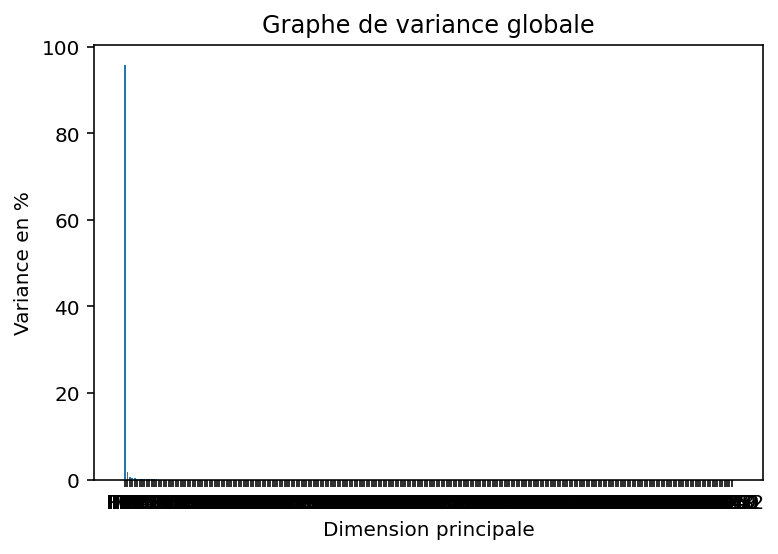

In [42]:
# TODO: Plot

var_pourcentage = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ["PC" + str(i) for i in range(1,len(var_pourcentage)+1)]

plt.bar(x=range(1,len(var_pourcentage)+1), height=var_pourcentage, tick_label = labels)
plt.ylabel("Variance en %")
plt.xlabel("Dimension principale")
plt.title("Graphe de variance globale")
plt.show()


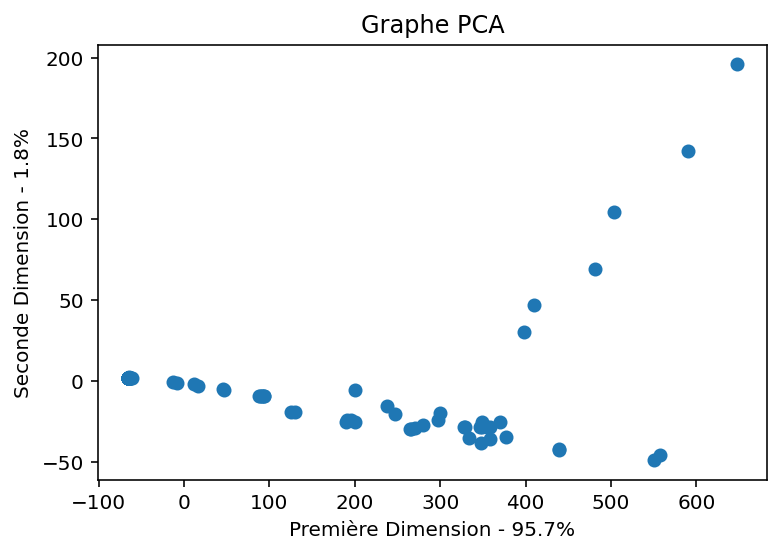

In [43]:
# On remarque que la quasi-totalité de la variation est sur la première composantes
# On va donc créer un graphe entre les deux premiers composants

pca_df = pd.DataFrame(pca_data, columns = labels)

plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title("Graphe PCA")
plt.xlabel("Première Dimension - {0}%".format(var_pourcentage[0]))
plt.ylabel("Seconde Dimension - {0}%".format(var_pourcentage[1]))
plt.show()

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

Comme on peut le voir sur le graphe ci dessus, 97,5% de la variation s'observe sur les deux premières composantes

## 5. Modèles de classification

Entrainez le modèle

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [44]:
SCORINGS = "balanced_accuracy"

<span style="color:red">
    Répondre ci-dessous
</span>

In [45]:
# model = linear_model.LogisticRegression(max_iter=10000)
model = ensemble.RandomForestClassifier(n_estimators=10)

# TODO: Try other models

model.fit(x_train, y_train)  # training

RandomForestClassifier(n_estimators=10)

In [46]:
# On va tester plusieurs models

nom = ["ensemble.RandomForestClassifier","ensemble.GradientBoostingClassifier",
       "ensemble.ExtraTreesClassifier","ensemble.BaggingClassifier", 
       "naive_bayes.MultinomialNB","naive_bayes.GaussianNB", 'naive_bayes.BernoulliNB()']

classifiers = [
    ensemble.RandomForestClassifier(n_estimators = 10),
    ensemble.GradientBoostingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.BaggingClassifier(),
    naive_bayes.MultinomialNB()
]

## 6. Évaluations

In [47]:
y_pred = model.predict(x_valid)  # predictions

score = metrics.balanced_accuracy_score(y_valid, y_pred)  # scoring

print(f"Balanced accuracy score model: {score:.3g}")
y_valid.value_counts()

Balanced accuracy score model: 0.501


0    23162
1      838
dtype: int64

In [48]:
# On calcule le balanced_accuracy_score de chaque model pour des paramètres définits

scores = []
for nom, model in zip(nom, classifiers):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_valid)
    score = metrics.balanced_accuracy_score(y_valid, y_pred)
    scores.append(score)

In [49]:
scores

[0.49995685563896797,
 0.5053924152843151,
 0.5,
 0.5026314911006095,
 0.6189858492794262]

### Code : Cross-Validation

Le code ci-dessus utilise une méthode simple (*hold out*) pour mesurer le score de validation. Utilisez la validation croisée (pour obtenir une estimation plus fiable) combinée à l'exploration des hyperparamètres (pour améliorer les résultats).

Vous pouvez changer la valeur du nombre de validation croisée (CV) selon la valeur de l'erreur et le temps d'entrainement des modèles (compromis).

In [48]:
CV = 10
SCORING = "balanced_accuracy"

In [55]:
%%time
model_selection.cross_val_score(ensemble.RandomForestClassifier(), x_train, y_train,
                               cv=CV, scoring=SCORING)

Wall time: 3min 17s


array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [54]:
%%time
model_selection.cross_val_score(ensemble.RandomForestClassifier(), x_train, y_train,
                               cv=5, scoring=SCORING)

Wall time: 1min 25s


array([0.5, 0.5, 0.5, 0.5, 0.5])

La ligne "%%time" dans les deux cellules ci dessus montrent leur temps d'execution. On voit ici que mettre le cv à 5 réduit considérablement le temps d'execution et facilite donc l'étude des hyperparamètres. On va donc placer à 5 la valeur du cv pour le modèle de RandomForestClassifier.

On a décidé d'utiliser le modèle MultinomialNB car sa balanced accuracy est la plus élevée des modèles que nous avons sélectionnés et de plus suite a des recherches on a vu qu'il était utilisé dans des cas d'études similaires à la notre.

In [55]:
# On cherche les meilleurs hyperparamètres pour MultinomialNB
model = naive_bayes.MultinomialNB()
model.fit(x_train,y_train)

y_pred = model.predict(x_valid)

params = {
    'alpha' : [ 0.0001, 0.001, 0.01, 0.1,  0.5, 1, 10 ]
    }

grid = model_selection.GridSearchCV(naive_bayes.MultinomialNB(), param_grid=params, n_jobs=-1, cv=CV, scoring=SCORING, verbose=5)
grid.fit(x_1hot_df,ys)

print('Train Accuracy : %.3f'%grid.best_estimator_.score(x_train, y_train))
print('Test Accuracy : %.3f'%grid.best_estimator_.score(x_valid, y_valid))
print('Best Accuracy Through Grid Search : %.3f'%grid.best_score_)
print('Best Parameters : ',grid.best_params_)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Train Accuracy : 0.784
Test Accuracy : 0.782
Best Accuracy Through Grid Search : 0.635
Best Parameters :  {'alpha': 0.001}


In [ ]:
# On cherche les meilleurs hyperparamètres pour RandomForestClassifier
model = ensemble.RandomForestClassifier()
model.fit(x_train,y_train)

y_pred = model.predict(x_valid)

params = {
    'n_estimators' : np.arange(10,200,20),
    'max_depth' : np.arange(10, 200, 20),
    }

grid = model_selection.GridSearchCV(ensemble.RandomForestClassifier(), param_grid=params, n_jobs=-1, cv=5, scoring=SCORING, verbose=5)
grid.fit(x_1hot_df,ys)

print('Train Accuracy : %.3f'%grid.best_estimator_.score(x_train, y_train))
print('Test Accuracy : %.3f'%grid.best_estimator_.score(x_valid, y_valid))
print('Best Accuracy Through Grid Search : %.3f'%grid.best_score_)
print('Best Parameters : ',grid.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


<span style="color:red">
    Répondre ci-dessous
</span>

#### Avant:
**Pour au moins 2 modèles (autres que les baselines) :**

* Donnez les résultats de la cross-validation ou du grid search sous forme de Boxplot (ou de diagramme à bâtons) pour:

    * La précision
    
    * Le rappel
    
    * Le f1-score
    
    * La `balanced_accuracy`


* Réalisez la matrice de confusion sur les prédictions (binaires) et décrivez la succinctement 

* Mesurez l'aire sous la courbe ROC (AUC) à l'aide de la fonction de Scikit-Learn (`roc_auc_score`) et comparez les modèles

#### Après:
* **Pour 2 des modèles** (au moins 1 autre que les 2 proposés en baselines) :

    * Pour différentes valeurs d'un des hyperparamètres, donnez les `balanced_accuracy` moyennes de la validation croisée sous forme de Boxplots (ou de diagramme à bâtons avec une barre d'erreur) : voir l'exemple présenté dans le graphique ci-dessous. 
    
    * Explicitez succinctement quelles observations en tirer concernant la stabilité des prédictions.

![](img/boxplot-cv.png)

<span style="color:red">
    Répondre ci-dessous
</span>

In [64]:
# On regarde le modèle RandomForestClassifier
# On choisi de regarder l'hyperparamètre "max_depth"
test_values = np.arange(10,71,10)
values = []
for x in range(len(test_values)):
    values.append([])
    
    # On calcule le cross_val_score pour différentes valeurs
    
    for i in test_values:
        model = ensemble.RandomForestClassifier(n_estimators=1, max_depth = i)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_train)
        score = model_selection.cross_val_score(ensemble.RandomForestClassifier(n_estimators=1, max_depth = i), x_train, y_train, cv=CV, scoring = SCORING).mean()
        values[x].append(score)

# On met ces valeurs dans une liste afin de pourvoir étudier leur variation
res = []       
for i in range(len(values)):
    res.append([])
    for j in range(len(values[i])):
        res[i].append(values[j][i])

Text(0.5, 1.0, 'RandomForestClassifier')

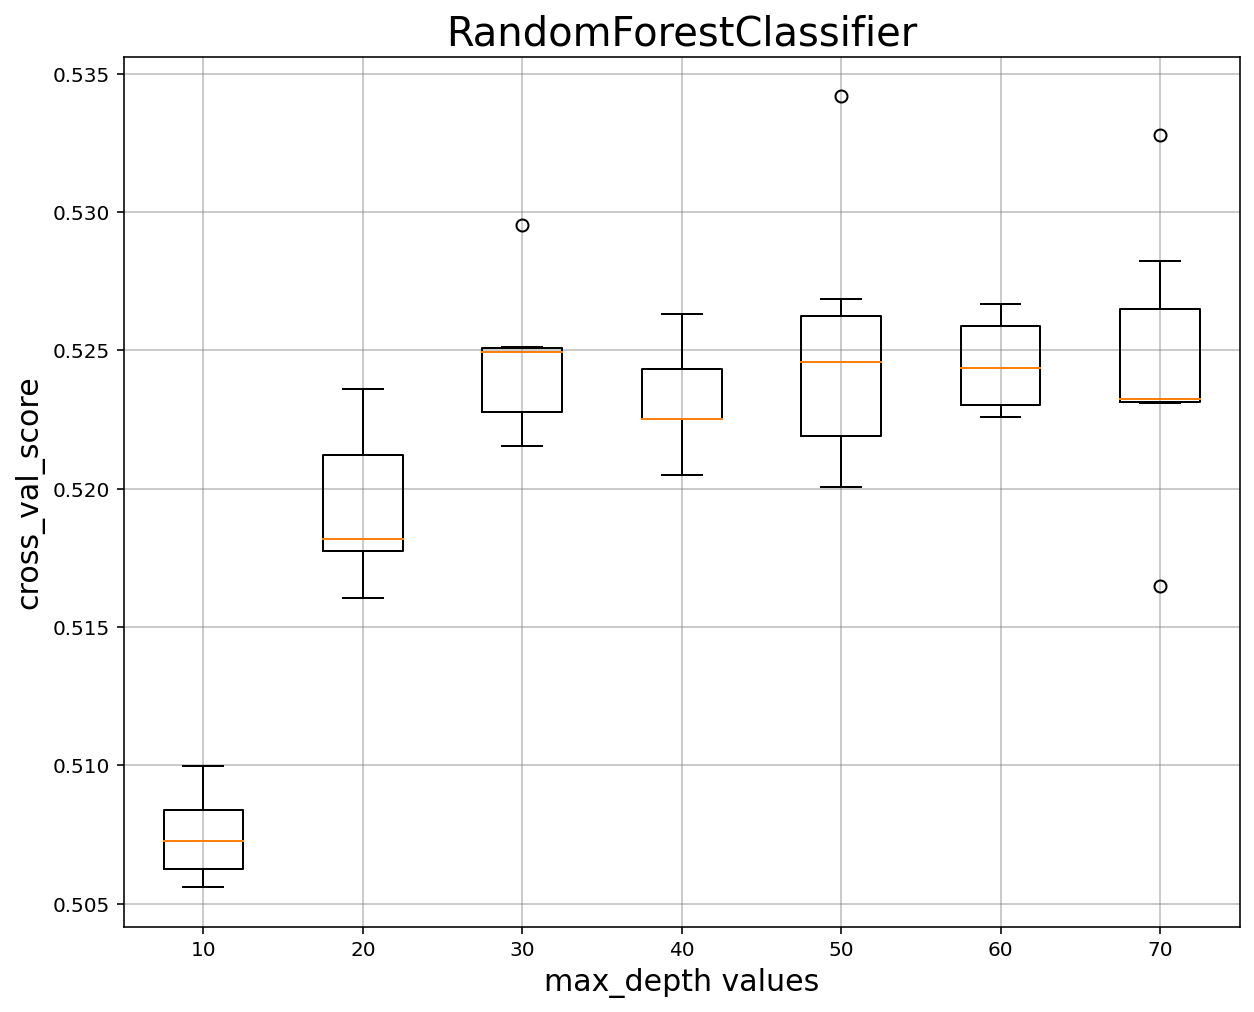

In [65]:
# On réalise un graphe de ces variations

fig1, ax = plt.subplots(figsize = (10,8))
ax.boxplot(res)
ax.yaxis.grid(True, linestyle='-', which='major', color='grey',alpha=0.5)
ax.xaxis.grid(True, linestyle='-', which='major', color='grey',alpha=0.5)
ax.set_ylabel('cross_val_score', fontsize = 15)
ax.set_xlabel('max_depth values', fontsize = 15)
ax.set_xticklabels(test_values)
ax.set_title('RandomForestClassifier', fontsize = 20)

On voit que le score de cross_val_score pour le modèle RandomForestClassifier se stabilise lorsque la valeur pe l'hyperparamètre max_depth dépasse 30.

In [58]:
# On regarde le modèle MultinomialNB
# On choisi de regarder l'hyperparamètre "alpha"
test_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 1.5, 2, 5]
values = []
for x in range(len(test_values)):
    values.append([])
    
    # On calcule le cross_val_score pour différentes valeurs
    
    for i in test_values:
        model = naive_bayes.MultinomialNB(alpha = i)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_train)
        score = model_selection.cross_val_score(naive_bayes.MultinomialNB(alpha = i), x_train, y_train, cv=CV, scoring = SCORING).mean()
        values[x].append(score)

# On met ces valeurs dans une liste afin de pourvoir étudier leur variation
res = []       
for i in range(len(values)):
    res.append([])
    for j in range(len(values[i])):
        res[i].append(values[j][i])

Text(0.5, 1.0, 'MultinomialNB')

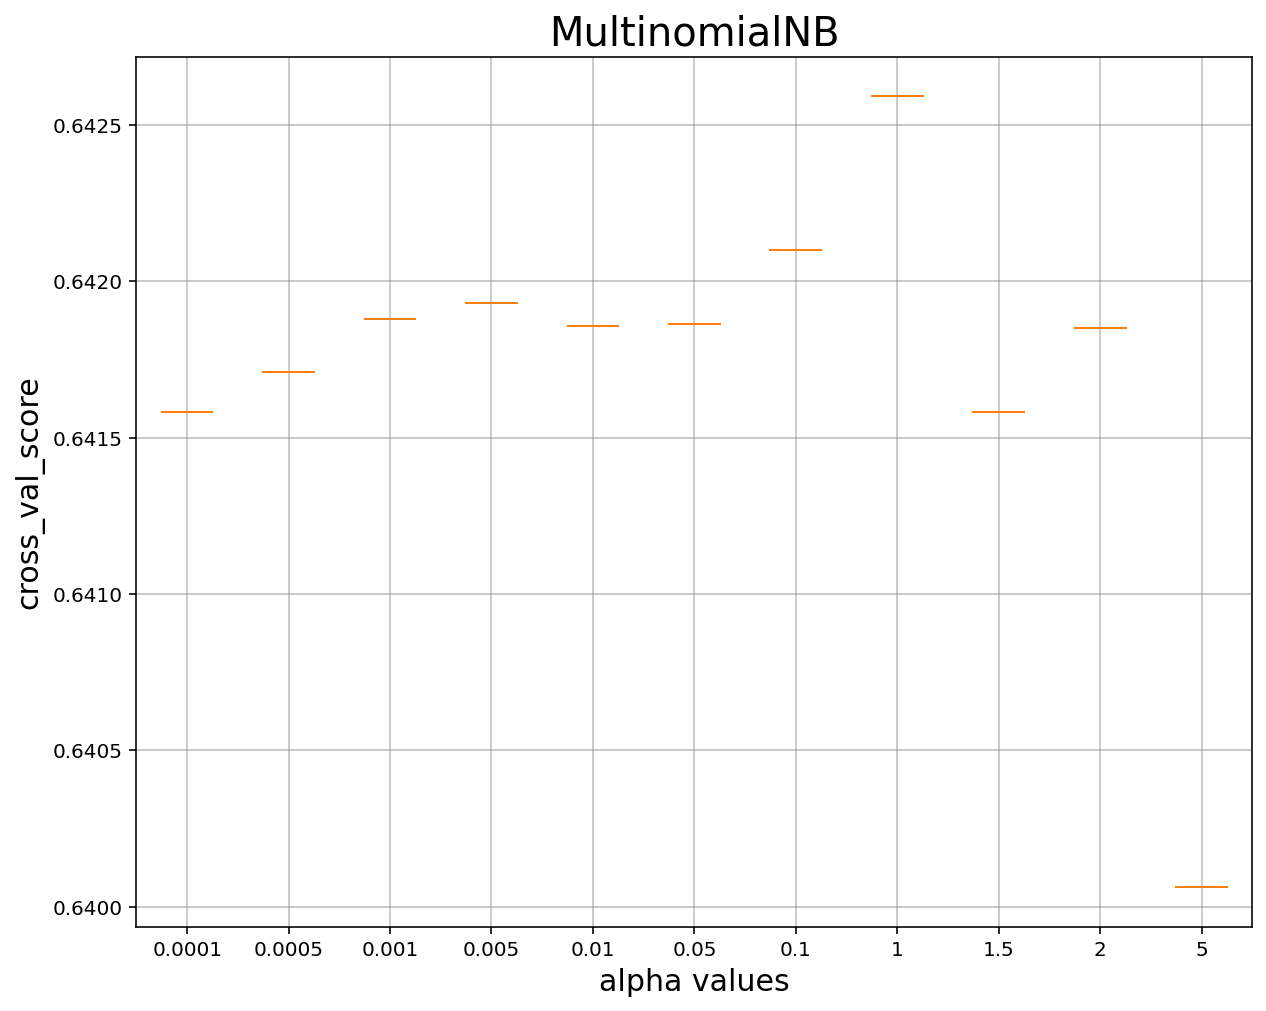

In [59]:
# On réalise un graphe de ces variations

fig1, ax = plt.subplots(figsize = (10,8))
ax.boxplot(res)
ax.yaxis.grid(True, linestyle='-', which='major', color='grey',alpha=0.5)
ax.xaxis.grid(True, linestyle='-', which='major', color='grey',alpha=0.5)
ax.set_ylabel('cross_val_score', fontsize = 15)
ax.set_xlabel('alpha values', fontsize = 15)
ax.set_xticklabels([0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 1.5, 2, 5])
ax.set_title('MultinomialNB', fontsize = 20)

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

Le modèle MultinomialNB se base sur une équation ce qui explique que les valeurs de cross_val_score du graphe sont les mêmes à chaque itération pour la même valeur d'alpha. Contrairement à RandomForestClassifier ou le cross_val_score varie d'une itération à l'autre. On voit que la valeur de cross_val_score du modèle MultinomialNB est la plus haute lorsque la valeur de l'hyperparamètre alpha est autour de 1.

* **Pour chacun de ces 2 modèles, à partir des données de validation créées précédemment** (`x_valid`, `y_valid`) :

    * Mesurez l'aire sous la courbe ROC (AUC) à l'aide de la fonction de Scikit-Learn (`roc_auc_score`) et comparez les modèles avec leur combinaison respective d'hyperparamètres offrant le meilleur résultat.

In [72]:
# TODO: ROC
# On nome les deux modèles de RandomForestClassifier, RFCopti pour le modèle ayant les hyperparamètres optimaux 
# et RFC pour le modèle de base
RFCopti = ensemble.RandomForestClassifier(max_depth = 50, max_features = 'auto', min_samples_leaf = 1
                                      , min_samples_split = 2, n_estimators = 10)
RFC = ensemble.RandomForestClassifier()
RFCopti.fit(x_train, y_train)
RFC.fit(x_train,y_train)

# On cherche la probabilité des modèles
RFCopti_pred = RFCopti.predict_proba(x_valid)
RFC_pred = RFC.predict_proba(x_valid)

# On garde uniquement les valeurs positives
RFCopti_pred = RFCopti_pred[:, 1]
RFC_pred = RFC_pred[:, 1]

RFCopti_auc = metrics.roc_auc_score(y_valid, RFCopti_pred)
RFC_auc = metrics.roc_auc_score(y_valid, RFC_pred)

print('RandomForestClassifier optimisé : AUROC = %.3f'%(RFCopti_auc))
print('RandomForestClassifier non optimisé : AUROC = %.3f'%(RFC_auc))

RandomForestClassifier optimisé : AUROC = 0.626
RandomForestClassifier non optimisé : AUROC = 0.730


In [74]:
MNBopti = naive_bayes.MultinomialNB(alpha = 0.001)
MNB = naive_bayes.MultinomialNB()

MNBopti.fit(x_train, y_train)
MNB.fit(x_train,y_train)

# On cherche la probabilité des modèles
MNBopti_pred = MNBopti.predict_proba(x_valid)
MNB_pred = MNB.predict_proba(x_valid)

# On garde uniquement les valeurs positives
MNBopti_pred = MNBopti_pred[:, 1]
MNB_pred = MNB_pred[:, 1]

MNBopti_auc = metrics.roc_auc_score(y_valid, MNBopti_pred)
MNB_auc = metrics.roc_auc_score(y_valid, MNB_pred)

print('RandomForestClassifier optimisé : AUROC = %.3f'%(MNBopti_auc))
print('RandomForestClassifier non optimisé : AUROC = %.3f'%(MNB_auc))

RandomForestClassifier optimisé : AUROC = 0.681
RandomForestClassifier non optimisé : AUROC = 0.679


<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

* **Pour le modèle et sa combinaison d'hyperparamètres offrant le meilleur résultat** :

    * Réalisez la matrice de confusion et décrivez-la succinctement.

In [ ]:
# TODO: Confusion Mtx

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

### Code : Essayez d'améliorer votre score

* Data augmentation (optionnel)
#### Avant
Vu le déséquilibre entre les classes à prédire (survive, died), on peut espérer améliorer le score en les rééquilibrant. Une approche typique est la génération de données (voir slides du cours 6). Une des méthodes de génération est implémentée dans le module `imblearn`.
#### Après
Vu le déséquilibre entre les classes à prédire (survive, died), on peut espérer améliorer le score en les rééquilibrant. Une approche typique est la génération de données (voir cours : `part-6-slides.pdf`). Une des méthodes de génération est [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE) (voir cours théorique), elle est notamment implémentée dans le module `imblearn`.

`imblearn` a été développé pour s'interfacer facilement avec `sklearn`.
Il propose notamment une version du `pipeline` qui permet l'intégration avec `sklearn`.

Ci-dessous voici un exemple de `pipe` intégrant `imblearn` et `sklearn`.

<span style="color:red">
    Répondre ci-dessous
</span>

In [ ]:
'''# TODO: Data augmentation

pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA()),
        ("resample", imblearn.over_sampling.SMOTE()),
        ("model", model),
    ]
)'''

### Explication de ce que vous avez réalisé, conclusion et perspectives

* Commencez par donner votre meilleur résultat obtenu lors de vos soumissions

* Expliquez le chemin qui vous y a conduit

    * Ce que vous avez essayé :

        * Ce qui a fonctionné

        * Ce qui n'a pas fonctionné et comment vous l'avez solutionné

    * Quelle méthode avez-vous utilisée pour choisir les hyperparamètres ?

    * Comparer la durée d'entrainement des principaux modèles utilisés ?

* Qu'auriez-vous fait si vous aviez eu plus de temps ?

<span style="color:red">
    Répondre ci-dessous
</span>

### Question (optionnelle)

* Qu'est-ce que le suréchantillonnage ? 

* En quoi pourrait-il être utile dans ce problème ?

<span style="color:red">
    Répondre ci-dessous
</span>

## 7. Enregistrer les prédictions

* Utilisez le code suivant pour faire des prédictions et pour les enregistrer sous forme de fichier ZIP
* Soumettez ce fichier ZIP sur [le site du challenge](https://competitions.codalab.org/competitions/30715#participate-submit_results)
("Participate > Submit/View Results > Submit")
* Faites de votre mieux pour être le ***premier sur le leaderboard !***

<span style="color:red">
    !! Ne pas oublier de modifier la commande de la prédiction selon les données et modèles choisis !!
</span>

* Données : `x_test_fact_df`, `x_test_1hot_df`

* Modèles : `model`, `search` (e.g., pour le `GridSearchCV`)

In [ ]:
'''predictions = model.predict(x_test_1hot_df)  # compute predictions
# VARS: x_test_df, x_test_fact_df, x_test_1hot_df, x_test_1hot_pcs
# Models: model, search


PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")'''

---

# Remarque sur le jeu de données

Le jeu de données ne contient pas de données médicales réelles. Nous ne sommes pas autorisés à partager ces **données confidentielles** provenant de patients en soins intensifs. Pour éviter ce problème, les données ont été remplacées par des **données artificielles**.

Afin d'avoir des données crédibles, elles ont été générées à l'aide d'un **Wasserstein GAN**.

Pour plus d'informations, voici une référence : <br />
[Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document) <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />

---